## 🧩 Importing Required Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel
from PIL import Image
import requests
from io import BytesIO
!pip install transformers sentence-transformers tqdm --quiet
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

sns.set_style("whitegrid")
pd.set_option('display.max_colwidth', None)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 📂 Loading the Dataset


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/dataset/train.csv")
test = pd.read_csv("/content/drive/MyDrive/dataset/test.csv")

print("Training data shape:", train.shape)
print("Test data shape:", test.shape)
train.head()

Training data shape: (75000, 4)
Test data shape: (75000, 3)


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)\nValue: 72.0\nUnit: Fl Oz\n",https://m.media-amazon.com/images/I/51mo8htwTHL.jpg,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butter Cookies, 8 Ounce (Pack of 4)\nBullet Point 1: Original Butter Cookies: Classic butter cookies made with real butter\nBullet Point 2: Variety Pack: Includes 4 boxes with 32 cookies total\nBullet Point 3: Occasion Perfect: Delicious cookies for birthdays, weddings, anniversaries\nBullet Point 4: Shareable Treats: Fun to give and enjoy with friends and family\nBullet Point 5: Salerno Brand: Trusted brand of delicious butter cookies since 1925\nValue: 32.0\nUnit: Ounce\n",https://m.media-amazon.com/images/I/71YtriIHAAL.jpg,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy Chicken with Rice, 1.9 Ounce (Pack of 6)\nBullet Point 1: Loaded with hearty long grain wild rice and vegetables\nBullet Point 2: Full of hearty goodness\nBullet Point 3: Single serve bowls\nBullet Point 4: Easy to prepare mix\nBullet Point 5: 0 grams trans fat\nValue: 11.4\nUnit: Ounce\n",https://m.media-amazon.com/images/I/51+PFEe-w-L.jpg,1.97
3,55858,"Item Name: Judee’s Blue Cheese Powder 11.25 oz - Gluten-Free and Nut-Free - Use in Seasonings and Salad Dressings - Great for Dips, Spreads and Sauces - Made in USA\nBullet Point 1: Add to your favorite appetizers, dips & spreads. Use to season popcorn or warmed pita chips.\nBullet Point 2: Sprinkle over french fries, fried chicken, mashed potatoes, roasted veggies, pasta, and more\nBullet Point 3: Made in a dedicated gluten-free facility and shipped in a standup, resealable pouch to ensure freshness\nBullet Point 4: Ingredients: Blue Cheese (Milk, Salt, Cultures, & Enzymes) and Disodium Phosphate\nBullet Point 5: Since 2009, Judee’s has been dedicated to providing fresh, allergy-conscious ingredients, great for your recipes and even better for your family\nProduct Description: Judees Powdered Blue Cheese cheddar cheese powder is an alternative to mozzarella cheese shredded or american cheese slices deli. Make your own alfredo sauce with heavy cream and black buffalo dip with this powder. It adds extra flavor to salad dressing like ranch dressing and great on pizza dough or cauliflower pasta. Add to macaroni and cheese or popcorn seasoning for more aroma and cheesy feel. Combine with mustard and other ingredients to create your own dressing for buffalo chicken or buffalo wings.\nValue: 11.25\nUnit: Ounce\n",https://m.media-amazon.com/images/I/41mu0HAToDL.jpg,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Ounce - 12 per case.\nBullet Point: kedem Sherry Cooking Wine, 12.7 Ounce - 12 per case.\nValue: 12.0\nUnit: Count\n",https://m.media-amazon.com/images/I/41sA037+QvL.jpg,66.49


## 🧾 Data Overview



In [4]:
train.info()
train.describe(include='all')
train.isnull().sum()
train.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        75000 non-null  int64  
 1   catalog_content  75000 non-null  object 
 2   image_link       75000 non-null  object 
 3   price            75000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB


np.int64(0)

## 🔍 Exploratory Data Analysis


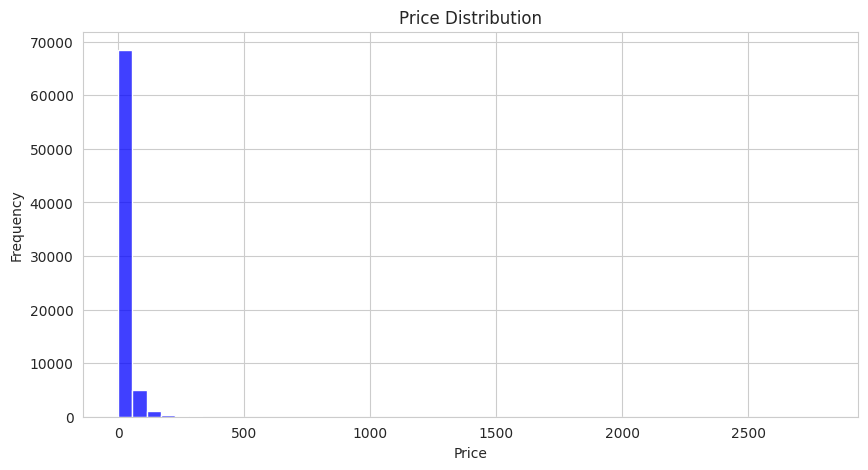

In [5]:
plt.figure(figsize=(10,5))
sns.histplot(train['price'], bins=50, color='blue')
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

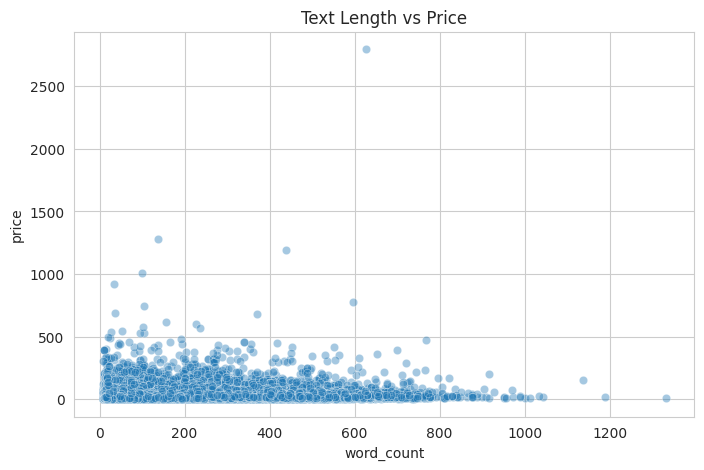

In [5]:
train['word_count'] = train['catalog_content'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,5))
sns.scatterplot(data=train, x='word_count', y='price', alpha=0.4)
plt.title("Text Length vs Price")
plt.show()

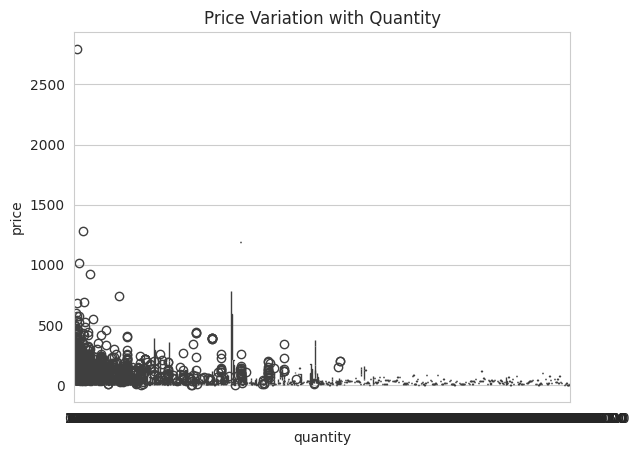

In [6]:
train['quantity'] = train['catalog_content'].str.extract(r'(\d+)\s?(pack|pcs|piece|unit|bottle)?', expand=False)[0].astype(float)
sns.boxplot(data=train, x='quantity', y='price')
plt.title("Price Variation with Quantity")
plt.show()

## 🧹 Text Preprocessing

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train['clean_text'] = train['catalog_content'].apply(clean_text)
test['clean_text'] = test['catalog_content'].apply(clean_text)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

## 🤖 Text Feature Extraction using Transformer (MiniLM)

In [2]:
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to("cuda")


# inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)
# inputs = {k: v.to("cuda") for k, v in inputs.items()}  # Ye line important



def get_embeddings(text_list, batch_size=32):
    embeddings = []
    model.eval()
    for i in tqdm(range(0, len(text_list), batch_size)):
        batch = text_list[i:i+batch_size]
        # Tokenize batch
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)
        # Move inputs to same device as model
        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        # Forward pass
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeds = outputs.last_hidden_state.mean(dim=1).cpu()  # back to CPU for numpy
        embeddings.append(batch_embeds)
    embeddings = torch.cat(embeddings)
    return embeddings.numpy()

train['text_emb'] = list(get_embeddings(train['clean_text'].tolist()))
test['text_emb'] = list(get_embeddings(test['clean_text'].tolist()))

NameError: name 'AutoModel' is not defined

## 🖼️ Image Feature Extraction

In [1]:
from pathlib import Path
import os, urllib
from tqdm import tqdm
from PIL import Image
import torch
from torchvision import models, transforms
import numpy as np

# 🔹 Setup download folder
download_folder = "/content/drive/MyDrive/src/image_downloads"
os.makedirs(download_folder, exist_ok=True)

# 🔹 Sequential download (Colab friendly & tqdm works)
train_paths = []
for link in tqdm(train['image_link'], desc="Downloading images"):
    try:
        filename = Path(link).name
        path = os.path.join(download_folder, filename)
        if not os.path.exists(path):
            urllib.request.urlretrieve(link, path)
        train_paths.append(path)
    except:
        train_paths.append(None)
train['image_path'] = train_paths

# 🔹 Pretrained ResNet50 + transform
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1]).to(device)
resnet.eval()

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# 🔹 Batch embeddings for speed
def get_image_features_batch(img_paths, batch_size=64):
    features_list = []
    for i in tqdm(range(0, len(img_paths), batch_size), desc="Extracting embeddings"):
        batch_imgs = []
        valid_paths = []
        for p in img_paths[i:i+batch_size]:
            try:
                img = Image.open(p).convert("RGB")
                batch_imgs.append(transform(img))
                valid_paths.append(p)
            except:
                batch_imgs.append(torch.zeros(3,224,224))
                valid_paths.append(None)
        batch_tensor = torch.stack(batch_imgs).to(device)
        with torch.no_grad():
            batch_features = resnet(batch_tensor).view(len(batch_imgs), -1).cpu().numpy()
        features_list.extend(batch_features)
    return np.array(features_list)

train['image_emb'] = list(get_image_features_batch(train['image_path'].tolist(), batch_size=64))

# 🔹 Brightness + Color Std (parallel, but safe)
def image_stats(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        arr = np.array(img)
        brightness = np.mean(arr)
        color_std = np.std(arr, axis=(0,1)).mean()
        return [brightness, color_std]
    except:
        return [0,0]

# Using simple list comprehension instead of multiprocessing (Colab stable)
stats = [image_stats(p) for p in tqdm(train['image_path'], desc="Brightness & Color") ]
train[['brightness','color_std']] = pd.DataFrame(stats, columns=['brightness','color_std'])

print("✅ Fast Image feature extraction completed! Embeddings + brightness + color_std ready.")




NameError: name 'train' is not defined

## 🧠 Combining Text and Image Features

In [12]:
# Filter out rows with None values in text_emb and image_emb, and check image_emb shape
train_filtered = train[
    train['text_emb'].notnull() &
    train['image_emb'].apply(lambda x: not np.array_equal(x, np.zeros(2048)) and x.shape == (2048,))
]

train_text_emb = np.vstack(train_filtered['text_emb'].values)
train_image_emb = np.vstack(train_filtered['image_emb'].values)

X = np.hstack([train_text_emb, train_image_emb])
y = train_filtered['price'].values

KeyError: 'image_emb'

In [ ]:
# Apply the image feature extraction function to the dataframes
train['image_emb'] = train['image_link'].apply(get_image_features)
test['image_emb'] = test['image_link'].apply(get_image_features)

## 🏗️ Model Building - Gradient Boosting + Neural Network Ensemble

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05)
gb.fit(X, y)
gb_preds = gb.predict(X)

# Simple MLP
model_nn = nn.Sequential(
    nn.Linear(X.shape[1], 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model_nn.parameters(), lr=1e-3)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)

for epoch in range(5):
    optimizer.zero_grad()
    output = model_nn(X_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

## 📏 Evaluation Metric - SMAPE

In [ ]:
def smape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))/2)) * 100

ensemble_preds = 0.6 * gb_preds + 0.4 * model_nn(X_tensor).detach().numpy().flatten()
print("SMAPE:", smape(y, ensemble_preds))


## 💾 Predicting on Test Set and Generating Submission

In [ ]:
# Assuming test embeddings already extracted
test_combined = np.hstack([test_text_emb, test_image_emb])
final_preds = 0.6 * gb.predict(test_combined) + 0.4 * model_nn(torch.tensor(test_combined, dtype=torch.float32)).detach().numpy().flatten()

submission = pd.DataFrame({
    'sample_id': test['sample_id'],
    'price': final_preds
})
submission.to_csv("test_out.csv", index=False)
submission.head()